In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Read the log file and parse the data into a DataFrame
with open("output.log", "r") as file:
    lines = file.readlines()

log_data = []
for line in lines:
    parts = line.strip().split(" - ")
    timestamp = parts[0]
    session_id = parts[1]
    tool = parts[2]
    log_data.append([timestamp, session_id, tool])

df = pd.DataFrame(log_data, columns=['Timestamp', 'Session_ID', 'Tool'])


In [42]:
# Calculate the frequency of tool usage
tool_frequency = df['Tool'].value_counts().reset_index()
tool_frequency.columns = ['Tool', 'Frequency']

In [43]:
# Reshape the data for plotting the heatmap
heatmap_data = tool_frequency.pivot(index=None, columns='Tool', values='Frequency')

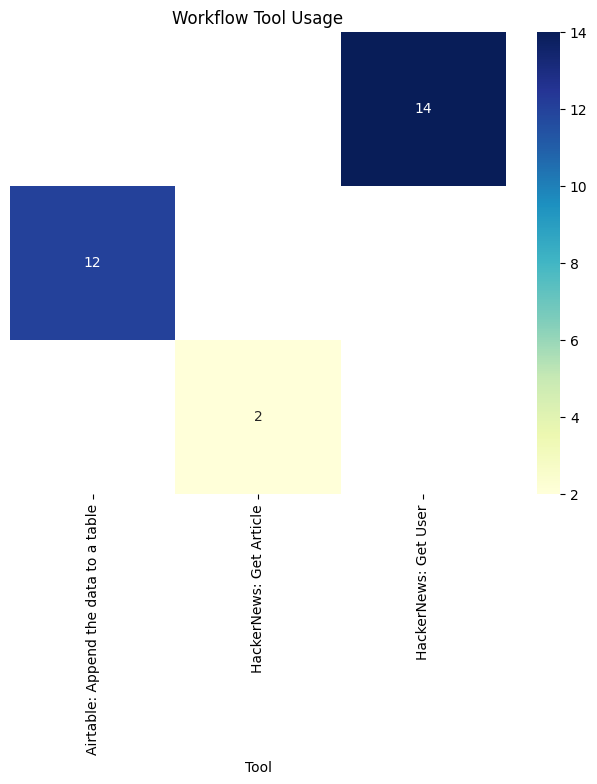

In [44]:
# Set up the heatmap figure
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')

# Add labels and title
plt.yticks([])
plt.xlabel('Tool')
plt.ylabel('')
plt.title('Workflow Tool Usage')

# Display the heatmap
plt.show()